In [1]:
# Get Dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import os
os.getcwd()
os.chdir('/users/angela/OneDrive/ANLT272_Healthcare_CaseStudies')

In [6]:
os.getcwd()

'/Users/angela/Library/CloudStorage/OneDrive-Personal/ANLT272_Healthcare_CaseStudies'

In [8]:
claims = pd.read_csv('./uopjan16_claims_in.csv', low_memory = False)

In [9]:
claims.shape

(1788544, 22)

In [10]:
eligibility = pd.read_csv('./uopjan16_enroll_in.csv')

In [11]:
NPDLookup = pd.read_csv('./uopjanref_rx_lookup.csv')

In [12]:
NPDLookup = NPDLookup.rename(columns = {'National Drug Code': 'NDC'})

In [13]:
# generate AC_AD NDC list
AC_AD = NPDLookup.loc[(NPDLookup['rx_group'] == 'ANTIDIABETICS')| (NPDLookup['rx_group'] =='ANTICOAGULANTS'), 'NDC'].drop_duplicates()

In [14]:
pharma_data = claims[(claims['rectype'] == 'P') & (claims['ndc'].notnull())]

In [15]:
pharma_data.loc[:, 'ndc'] = pharma_data['ndc'].str.lstrip('0')

/Users/angela/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
Anticoagulant = NPDLookup.loc[(NPDLookup['rx_group'] == 'ANTICOAGULANTS')].NDC.drop_duplicates()
Antidiabetics = NPDLookup.loc[(NPDLookup['rx_group'] == 'ANTIDIABETICS')].NDC.drop_duplicates()                           

In [17]:
Anticoagulant = Anticoagulant.astype(str)
Antidiabetics = Antidiabetics.astype(str)
AC_AD = AC_AD.astype(str)

In [18]:
column_name = 'ndc'
AC_df = pd.DataFrame({column_name: Anticoagulant})
AD_df = pd.DataFrame({column_name: Antidiabetics})

In [19]:
AC_df['rx_group'] = 'Anticoagulants'
AD_df['rx_group'] = 'Antidiabetics'

In [20]:
mergedADAC_df = pd.concat([AC_df, AD_df], axis=0, ignore_index=True)

In [21]:
mergedADAC_df.head()

,ndc,rx_group
0,3089321,Anticoagulants
1,3089421,Anticoagulants
2,7323011,Anticoagulants
3,7323611,Anticoagulants
4,56016870,Anticoagulants


In [22]:
# merge anticoagulants dataframe and antidiabetics dataframe with pharma_data
pharma_data = pd.merge(pharma_data, mergedADAC_df, on = 'ndc', how = 'left')

In [23]:
pharma_data.shape

(716503, 23)

In [24]:
on_index_df = pharma_data[(pharma_data['from_dt'] >= '2013-01-01') & (pharma_data['from_dt'] <= '2013-03-31')]

In [25]:
on_index_df.shape

(78132, 23)

In [26]:
on_index_df[on_index_df['rx_group'].isnull()].ndc.unique()

array(['65702049210', '69421030', '62037083001', ..., '99207052560',
       '16729003101', '63739028431'], dtype=object)

In [27]:
# this is for all anticoagulants claims
AC_claims = pharma_data[pharma_data['ndc'].isin(Anticoagulant)]

In [28]:
neither_claims = pharma_data[~pharma_data['ndc'].isin(AC_AD)]

In [29]:
# add age to the eligibility file
eligibility['age'] = 2013 - eligibility['der_yob']

In [30]:
# add age buckets
bin_edges = [0, 18, 50, 65, 75, 130]
eligibility['age_bucket'] = pd.cut(eligibility['age'], bins = bin_edges, labels=['0-18', '19-50', '51-65','66-75', '76+'])

In [31]:
columns_to_select = ['pat_id', 'der_sex', 'age', 'pat_region', 'age_bucket']
elig_subset = eligibility[columns_to_select]

In [32]:
#merge on_index_data with eligibility subset dataframe
on_index_df = on_index_df.merge(elig_subset, on = 'pat_id', how = 'left')

In [33]:
on_index_df.shape

(78132, 27)

In [34]:
on_index_df['from_dt'] = pd.to_datetime(on_index_df['from_dt'], format = '%Y-%m-%d')

In [35]:
first_occurances = on_index_df.groupby(['pat_id', 'rx_group'])['from_dt'].idxmin()

In [36]:
first_occurances_df = on_index_df.loc[first_occurances]

In [37]:
first_occurances_df.pat_id.nunique()

5796

In [38]:
on_index_df[on_index_df['pat_id'] == '0390AAAAAAVBDQXQ'].head()

,pat_id,rec_spec,rectype,ALLOWED,DAYSSUP,QUAN,rec_ix,from_dt,to_dt,prov_id,...,diag4,ptypeflg,pos,cluspvid,conf_num,rx_group,der_sex,age,pat_region,age_bucket
2708,0390AAAAAAVBDQXQ,NaN,P,17.12,10.0,20.0,353057225,2013-01-07,2013-01-07,0309AAAAAAAAAXHE,...,NaN,0,00,0323AAAAAAAACUQW,NaN,NaN,F,57.0,MW,51-65
2709,0390AAAAAAVBDQXQ,NaN,P,6.20,30.0,60.0,353057226,2013-01-09,2013-01-09,0309AAAAAAAAAXHE,...,NaN,0,00,NaN,NaN,Antidiabetics,F,57.0,MW,51-65
2710,0390AAAAAAVBDQXQ,NaN,P,2.66,30.0,45.0,353057227,2013-01-09,2013-01-09,0309AAAAAAAAAXHE,...,NaN,0,00,0358AAAAAAAADYKI,NaN,NaN,F,57.0,MW,51-65
2711,0390AAAAAAVBDQXQ,NaN,P,3.92,60.0,60.0,353057230,2013-01-17,2013-01-17,0309AAAAAAAAAXHE,...,NaN,0,00,NaN,NaN,NaN,F,57.0,MW,51-65
2712,0390AAAAAAVBDQXQ,NaN,P,6.33,30.0,60.0,353057231,2013-01-17,2013-01-17,0309AAAAAAAAAXHE,...,NaN,0,00,0358AAAAAAAADYKI,NaN,Anticoagulants,F,57.0,MW,51-65


In [39]:
# the sample size for patients who have either anticoagulants or antidiabetics claims
first_occurances_df.groupby(['rx_group', 'der_sex']).pat_id.nunique()

rx_group        der_sex
Anticoagulants  F           434
                M           495
Antidiabetics   F          2609
                M          2465
Name: pat_id, dtype: int64

In [40]:
# the sample size for patients who have either anticoagulants or antidiabetics claims: group by age bucket
first_occurances_df.groupby(['rx_group','age_bucket']).pat_id.nunique()

rx_group        age_bucket
Anticoagulants  0-18             5
                19-50          142
                51-65          367
                66-75          171
                76+            244
Antidiabetics   0-18           136
                19-50         1372
                51-65         2471
                66-75          709
                76+            384
Name: pat_id, dtype: int64

In [41]:
pat_more_than_one = first_occurances_df['pat_id'].value_counts()
pat_list = pat_more_than_one[pat_more_than_one > 1].index.tolist()

In [42]:
pat_more_than_one_df = pd.DataFrame({'pat_id': pat_list})

In [43]:
merged_age_df = pat_more_than_one_df.merge(eligibility, on = 'pat_id', how = 'left')

In [44]:
# the sample size for patients who have both anticoagulants and antidiabetics claims
merged_age_df.groupby(['der_sex']).pat_id.nunique()

der_sex
F     99
M    108
Name: pat_id, dtype: int64

In [45]:
# the sample size for patients who have both anticoagulants and antidiabetics claims: group by age bucket
merged_age_df.groupby(['age_bucket']).pat_id.nunique()

age_bucket
0-18      0
19-50    25
51-65    96
66-75    44
76+      42
Name: pat_id, dtype: int64

In [46]:
# the sample size for patients who have neither anticoagulants or antidiabetics claims
first_occurances_df[first_occurances_df['rx_group'].isnull()].pat_id.nunique()

0

In [47]:
from datetime import datetime, timedelta
claims['to_dt'] = pd.to_datetime(claims['to_dt'])
to_date = pd.to_datetime('2013-01-01')
oneEighty =  to_date - timedelta(days=180)

In [48]:
# generate a pre-index claims: pre index is defined as 180 days prior to the first date of index(1-1-2013)
pre_index_hos = claims[(claims['rectype'] == 'F') & (claims['to_dt'] <= to_date) & (claims['to_dt']>= oneEighty)]

In [49]:
pre_index_hos.shape

(1321, 22)

In [50]:
pre_index_hos_AC_AD = first_occurances_df.merge(pre_index_hos, on = 'pat_id', how = 'inner')

In [51]:
pre_index_hos_AC_AD.shape

(1414, 48)

In [52]:
#pre_index_hospitalized patients whose had antidiabetics or anticoagulants drugs 
pre_index_hos_AC_AD.groupby(['rx_group']).pat_id.nunique()

rx_group
Anticoagulants    166
Antidiabetics     350
Name: pat_id, dtype: int64

In [53]:
pre_index_hos_more_than_one = pat_more_than_one_df.merge(pre_index_hos, on = 'pat_id', how = 'inner')

In [54]:
#pre_index_hospitalized patients whose had both antidiabetics and anticoagulants drugs 
pre_index_hos_more_than_one.pat_id.nunique()

34

In [55]:
#generate congested heart failure list with ICD9
claims_icd9 = ['428', '4280', '4281', '4282', '42820', '42821','42822','42823','42830','42831','42832','42833',
               '42840','42841','42842','42843','4289']

In [56]:
matching_diagnoses = claims[claims[['diag1', 'diag2', 'diag3', 'diag4']].apply(lambda x: x.isin(claims_icd9)).any(axis = 1)]

In [57]:
#preprocessing date filters
matching_diagnoses['to_dt'] = pd.to_datetime(matching_diagnoses['to_dt'])
to_date = pd.to_datetime('2013-03-31')
oneEighty =  to_date - timedelta(days=180)

/Users/angela/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
pre_CHF_raw = matching_diagnoses[(matching_diagnoses['to_dt'] <= to_date) & (matching_diagnoses['to_dt']>= oneEighty)]

In [59]:
pre_CHF_df = first_occurances_df.merge(pre_CHF_raw, on = 'pat_id', how = 'inner')

In [60]:
pre_CHF_df.shape

(5057, 48)

In [61]:
#pre_index patients with congested heart failures whose had either antidiabetics or anticoagulants drugs 
pre_CHF_df.groupby('rx_group').pat_id.nunique()

rx_group
Anticoagulants    125
Antidiabetics     198
Name: pat_id, dtype: int64

In [62]:
pre_CHF_more_than_one = pat_more_than_one_df.merge(pre_CHF_df, on = 'pat_id', how = 'inner')

In [63]:
#pre_index patients with congested heart failures whose had both antidiabetics and anticoagulants drugs 
pre_CHF_more_than_one.pat_id.nunique()

33

In [65]:
# generate bblocker list
bblocker_raw = pd.read_csv('./bblocker.csv')

In [66]:
matching_blocker = claims[(claims['rectype'] == 'P') & (claims['ndc'].notnull())] 

In [67]:
matching_blocker['ndc'] = matching_blocker['ndc'].astype(str)
bblocker_raw['NDC'] = bblocker_raw['NDC'].astype(str)

/Users/angela/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
matching_blocker = matching_blocker.merge(bblocker_raw, left_on = 'ndc', right_on = 'NDC', how = 'left')

In [69]:
#preprocessing date filters for from_date
matching_blocker['from_dt'] = pd.to_datetime(matching_blocker['from_dt'])
from_date = pd.to_datetime('2013-01-01')
oneEighty =  from_date - timedelta(days=180)

In [70]:
pre_bblocker_raw = matching_blocker[(matching_blocker['from_dt'] <= from_date) & (matching_blocker['from_dt']>= oneEighty)]

In [71]:
pre_bblocker_df = first_occurances_df.merge(pre_bblocker_raw, on = 'pat_id', how = 'inner')

In [72]:
pre_bblocker_df.shape

(139172, 49)

In [73]:
#pre_index patients with bblocker whose had either antidiabetics or anticoagulants drugs 
pre_bblocker_df.groupby('rx_group').pat_id.nunique()

rx_group
Anticoagulants     862
Antidiabetics     4686
Name: pat_id, dtype: int64

In [74]:
pre_bblocker_more_than_one = pat_more_than_one_df.merge(pre_bblocker_df, on = 'pat_id', how = 'inner')

In [75]:
#pre_index patients with bblocker whose had both antidiabetics and anticoagulants drugs 
pre_bblocker_more_than_one.pat_id.nunique()

200

In [76]:
# number of post index prescriptions for the index drug. post index = from_dt + to_dt += 180 days
pharma_data['from_dt'] = pd.to_datetime(pharma_data['from_dt'])
to_date = pd.to_datetime('2013-03-31')
oneEighty =  to_date + timedelta(days=180)

In [77]:
post_index_df = pharma_data[(pharma_data['from_dt'] >= '2013-01-01') & (pharma_data['from_dt'] <= oneEighty)]

In [78]:
# total post index rx for anticoagulants 
rx_counts_AC = post_index_df[(post_index_df['ndc'].notnull()) & (post_index_df['rx_group'] == 'Anticoagulants')].groupby('pat_id').size().reset_index(name='prescription_count')

In [79]:
# total post index rx for antidiabetics
rx_counts_AD = post_index_df[(post_index_df['ndc'].notnull()) & (post_index_df['rx_group'] == 'Antidiabetics')].groupby('pat_id').size().reset_index(name='prescription_count')

In [80]:
# total post index rx for anticoagulants
rx_counts_AC.describe()

,prescription_count
count,970.000000
mean,5.409278
std,4.277345
min,1.000000
25%,3.000000
50%,4.000000
75%,8.000000
max,54.000000


In [81]:
# total post index rx for antidiabetics
rx_counts_AD.describe()

,prescription_count
count,5089.000000
mean,7.635095
std,6.059930
min,1.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,50.000000


In [82]:
rx_counts_both = post_index_df[(post_index_df['ndc'].notnull()) &  (post_index_df['rx_group'].notnull())].groupby('pat_id').size().reset_index(name='prescription_count')

In [83]:
# total post index rx for both anticoagulants and antidiabetics
rx_counts_both.describe()

,prescription_count
count,5796.000000
mean,7.609041
std,6.079628
min,1.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,54.000000


In [84]:
filtered_df = post_index_df[(post_index_df['rx_group'] == 'Antidiabetics') | (post_index_df['rx_group'] == 'Anticoagulants')]

In [85]:
patient_counts = filtered_df.groupby('pat_id')['rx_group'].nunique()

In [86]:
patients_with_both = patient_counts[patient_counts == 2].index.tolist() 

In [87]:
patients_with_both = pd.DataFrame({'pat_id': patients_with_both})

In [88]:
patients_with_both['pat_id'] = patients_with_both['pat_id'].astype(str)
filtered_df['pat_id'] = filtered_df['pat_id'].astype(str)

/Users/angela/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [89]:
post_idx_DS_both = filtered_df.merge(patients_with_both, on='pat_id', how = 'inner')

In [90]:
post_idx_DS_both_df = post_idx_DS_both.groupby('pat_id')['DAYSSUP'].sum().reset_index()

In [91]:
# calculate post index rx day supply for both anticoagulants and antidiabetics
post_idx_DS_both_df['DAYSSUP'].describe()

count     263.000000
mean      507.486692
std       275.448224
min        36.000000
25%       300.000000
50%       480.000000
75%       660.000000
max      1710.000000
Name: DAYSSUP, dtype: float64

In [92]:
post_idx_DS_AC = filtered_df[filtered_df['rx_group'] == 'Anticoagulants'].groupby('pat_id')['DAYSSUP'].sum().reset_index()

In [93]:
post_idx_DS_AC['DAYSSUP'].describe()

count     970.000000
mean      214.051546
std       130.649799
min         3.000000
25%       120.000000
50%       210.000000
75%       270.000000
max      1048.000000
Name: DAYSSUP, dtype: float64

In [94]:
post_idx_DS_AD = filtered_df[filtered_df['rx_group'] == 'Antidiabetics'].groupby('pat_id')['DAYSSUP'].sum().reset_index()

In [95]:
post_idx_DS_AD['DAYSSUP'].describe()

count    5089.000000
mean      320.083513
std       223.743902
min         0.000000
25%       180.000000
50%       270.000000
75%       450.000000
max      1800.000000
Name: DAYSSUP, dtype: float64

In [96]:
import pandas as pd

# Create separate DataFrames for each section
at_index_data = {
    'Variable': ['N', 'Male', 'Age 0-18', 'Age 19-50', 'Age 51-65', 'Age 66-75', 'Age 76+'],
    'Anti-Diabetic_n': [5074, 2465, 136, 1372, 2471, 709, 384],
    'Anticoagulant_n': [929, 495, 5, 142, 367, 171, 244],
    'Both_n': [207, 108, 0, 25, 96, 44, 42],
    'Neither_n': [0, 0, 0, 0, 0, 0, 0]
}



# Create DataFrames
at_index_df = pd.DataFrame(at_index_data)


# Calculate percentages
at_index_df['Anti-Diabetic_%'] = (at_index_df['Anti-Diabetic_n'] / at_index_df['Anti-Diabetic_n'].sum() * 100).round(2).astype(str) + '%'
at_index_df['Anticoagulant_%'] = (at_index_df['Anticoagulant_n'] / at_index_df['Anticoagulant_n'].sum() * 100).round(2).astype(str) + '%'
at_index_df['Both_%'] = (at_index_df['Both_n'] / at_index_df['Both_n'].sum() * 100).round(2).astype(str) + '%'
at_index_df['Neither_%'] = (at_index_df['Neither_n'] / at_index_df['Neither_n'].sum() * 100).round(2).astype(str) + '%'


# Combine DataFrames
result_df = pd.concat([at_index_df], keys=['At Index'])

# Reset the index and set column names
result_df.reset_index(level=0, inplace=True)
result_df.columns.name = 'IDX_Group'

# Reorder columns
result_df = result_df[['Variable', 'Anti-Diabetic_n', 'Anti-Diabetic_%', 'Anticoagulant_n', 'Anticoagulant_%', 'Both_n', 'Both_%', 'Neither_n', 'Neither_%']]

# Fill NaN values with empty strings
result_df = result_df.fillna('')

# Display the result DataFrame
print(result_df)



IDX_Group   Variable  Anti-Diabetic_n Anti-Diabetic_%  Anticoagulant_n  \
0                  N             5074          40.23%              929   
1               Male             2465          19.55%              495   
2           Age 0-18              136           1.08%                5   
3          Age 19-50             1372          10.88%              142   
4          Age 51-65             2471          19.59%              367   
5          Age 66-75              709           5.62%              171   
6            Age 76+              384           3.04%              244   

IDX_Group Anticoagulant_%  Both_n  Both_%  Neither_n Neither_%  
0                  39.48%     207  39.66%          0      nan%  
1                  21.04%     108  20.69%          0      nan%  
2                   0.21%       0    0.0%          0      nan%  
3                   6.03%      25   4.79%          0      nan%  
4                   15.6%      96  18.39%          0      nan%  
5                

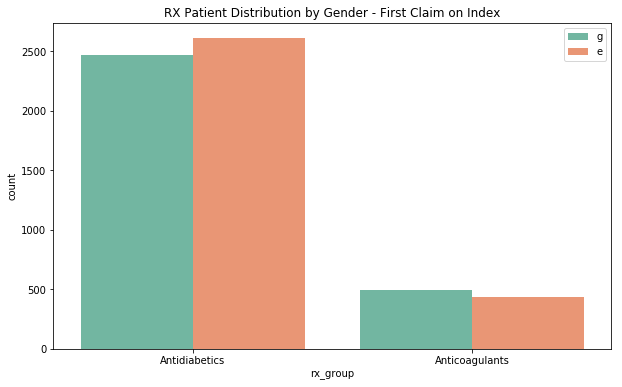

In [97]:
plt.figure(figsize = (10,6))
sns.countplot(data = first_occurances_df, x = "rx_group", hue = "der_sex", palette="Set2")
plt.xlabel("rx_group")
plt.ylabel("count")
plt.legend("gender")
plt.title("RX Patient Distribution by Gender - First Claim on Index")
plt.show()